In [ ]:
# annotation과 image 디렉토리 설정. annotation디렉토리에 있는 파일 확인. 
import os
from pathlib import Path

HOME_DIR = str(Path.home())

ANNO_DIR = os.path.join(HOME_DIR, 'DLCV/data/Dog_face/annotation')
IMAGE_DIR = os.path.join(HOME_DIR, 'DLCV/data/Dog_face/images')
print(ANNO_DIR)

files = os.listdir(ANNO_DIR)
print('파일 개수는:',len(files))
print(files)

In [ ]:
import glob
import xml.etree.ElementTree as ET

for xml_file in files:
    xml_path = os.path.join(ANNO_DIR, xml_file)
    xml_file = open(xml_path, 'rt', encoding='UTF8')
    
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    for obj in root.findall('object'):
        class_name = obj.find('name')
        original = class_name.text
        if original == 'Dog Face':
            modified = original.replace(r'Dog Face', r'Dog face')
            class_name.text = modified
            tree.write(xml_path)
        else:
            pass

In [16]:
images = sorted(os.listdir(IMAGE_DIR))
xmls = sorted(os.listdir(ANNO_DIR))

i = 1
for image, xml in zip(images, xmls):
    
    # 확장자를 제외한 파일명이 일치하는지 확인
    image_name, image_extension = os.path.splitext(image)
    xml_name, xml_extension = os.path.splitext(xml)
    
    if image_name == xml_name:
        pass
    else:
        print(image_name, xml_name)


    # 이미지 파일명 변경
    image_src = os.path.join(IMAGE_DIR, image)
    image_dst = 'Dog_face_{}.jpg'.format(i)
    image_dst = os.path.join(IMAGE_DIR, image_dst)
    os.rename(image_src, image_dst)
    
    # 주석 파일명 변경
    xml_src = os.path.join(ANNO_DIR, xml)
    xml_dst = 'Dog_face_{}.xml'.format(i)
    xml_dst = os.path.join(ANNO_DIR, xml_dst)
    os.rename(xml_src, xml_dst)
    
    # 주석의 'filename' 변경
    xml_file = open(xml_dst, 'rt', encoding='UTF8')

    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    xml_name = root.find('filename')
    original = xml_name.text
    modified = original.replace(image, r'Dog_face_{}.jpg'.format(i))
    xml_name.text = modified
    tree.write(xml_dst) 
   
    i = i + 1

In [3]:
import glob
import xml.etree.ElementTree as ET

classes_map = {'Dog face':0}

def xml_to_csv(path, output_filename):
    xml_list = []
    # xml 확장자를 가진 모든 파일의 절대 경로로 xml_file할당. 
    with open(output_filename, "w") as train_csv_file:
        for xml_file in glob.glob(path + '/*.xml'):
            # xml 파일을 parsing하여 XML Element형태의 Element Tree를 생성하여 object 정보를 추출. 
            tree = ET.parse(xml_file)
            root = tree.getroot()
            # 파일내에 있는 모든 object Element를 찾음. 
            full_image_name = os.path.join(IMAGE_DIR, root.find('filename').text)
            value_str_list = ' '
            for obj in root.findall('object'):
                xmlbox = obj.find('bndbox')
                class_name = obj.find('name').text
                x1 = int(xmlbox.find('xmin').text)
                y1 = int(xmlbox.find('ymin').text)
                x2 = int(xmlbox.find('xmax').text)
                y2 = int(xmlbox.find('ymax').text)
                # 
                class_id = classes_map[class_name]
                value_str = ('{0},{1},{2},{3},{4}').format(x1, y1, x2, y2, class_id)
                # object별 정보를 tuple형태로 object_list에 저장. 
                value_str_list = value_str_list+value_str+' '
        
            train_csv_file.write(full_image_name+' '+ value_str_list+'\n')
        # xml file 찾는 for loop 종료 

In [18]:
xml_to_csv(ANNO_DIR, os.path.join(ANNO_DIR,'Dog_face_annotation.csv'))
print(os.path.join(ANNO_DIR,'Dog_face_annotation.csv'))

/home/dsl001/DLCV/data/Dog_face/annotation/Dog_face_annotation.csv


In [4]:
# !cat /home/dsl001/DLCV/data/Dog/annotation/Dog_annotation.csv

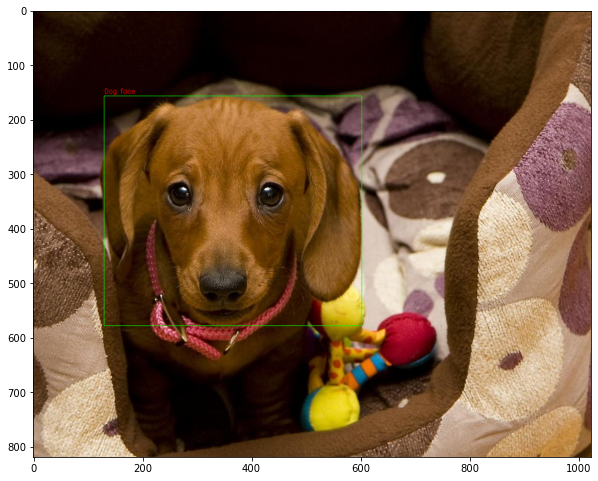

In [5]:
import cv2
import os
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

xml_file = os.path.join(ANNO_DIR, 'Dog_face_5000.xml')

tree = ET.parse(xml_file)
root = tree.getroot()

image_name = root.find('filename').text
full_image_name = os.path.join(IMAGE_DIR, image_name)

img = cv2.imread(full_image_name)
# opencv의 rectangle()는 인자로 들어온 이미지 배열에 그대로 사각형을 그려주므로 별도의 이미지 배열에 그림 작업 수행. 
draw_img = img.copy()
# OpenCV는 RGB가 아니라 BGR이므로 빨간색은 (0, 0, 255)
green_color=(0, 255, 0)
red_color=(0, 0, 255)

# 파일내에 있는 모든 object Element를 찾음.
objects_list = []
for obj in root.findall('object'):
    xmlbox = obj.find('bndbox')
    
    left = int(xmlbox.find('xmin').text)
    top = int(xmlbox.find('ymin').text)
    right = int(xmlbox.find('xmax').text)
    bottom = int(xmlbox.find('ymax').text)
    
    class_name=obj.find('name').text
    
    # draw_img 배열의 좌상단 우하단 좌표에 녹색으로 box 표시 
    cv2.rectangle(draw_img, (left, top), (right, bottom), color=green_color, thickness=1)
    # draw_img 배열의 좌상단 좌표에 빨간색으로 클래스명 표시
    cv2.putText(draw_img, class_name, (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, red_color, thickness=1)

img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(img_rgb)

In [2]:
import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

Using TensorFlow backend.
/home/dsl001/anaconda3/envs/tf113/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dsl001/anaconda3/envs/tf113/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dsl001/anaconda3/envs/tf113/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/dsl001/anaconda3/

In [3]:
import sys, os

LOCAL_PACKAGE_DIR = os.path.abspath("./keras-yolo3")
sys.path.append(LOCAL_PACKAGE_DIR)

from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data

In [4]:
from train import get_classes, get_anchors
from train import create_tiny_model, data_generator, data_generator_wrapper

BASE_DIR = os.path.join(HOME_DIR, 'DLCV/Detection/yolo/keras-yolo3')

## 학습을 위한 기반 환경 설정. annotation 파일 위치, epochs시 저장된 모델 파일, Object클래스 파일, anchor 파일.
annotation_path = os.path.join(ANNO_DIR, 'Dog_face_annotation.csv')
log_dir = os.path.join(BASE_DIR, 'snapshots/Dog_face/')
classes_path = os.path.join(BASE_DIR, 'model_data/Dog_face_classes.txt')
anchors_path = os.path.join(BASE_DIR,'model_data/tiny_yolo_anchors.txt')

class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)
print(class_names, num_classes)
print(anchors)

['Dog face'] 1
[[ 10.  14.]
 [ 23.  27.]
 [ 37.  58.]
 [ 81.  82.]
 [135. 169.]
 [344. 319.]]


#### yolo 모델 학습을 위한 전반적인 파라미터를 config 클래스로 설정하고 필요시 이를 수정하여 학습. 

In [5]:
# csv annotation 파일을 읽어서 lines 리스트로 만듬. 
with open(annotation_path) as f:
    lines = f.readlines()

class config:
    #tiny yolo로 모델로 초기 weight 학습 원할 시 아래를 tiny-yolo.h5로 수정. 
    initial_weights_path=os.path.join(BASE_DIR, 'model_data/yolo-tiny.h5')
    # input_shape는 고정. 
    input_shape=(416, 416)
    # epochs는 freeze, unfreeze 2 step에 따라 설정. 
    first_epochs=1000
    first_initial_epochs=0
    second_epochs=10000
    second_initial_epochs=1000
    # 학습시 batch size, train,valid건수, epoch steps 횟수  
    batch_size = 4
    val_split = 0.1   
    num_val = int(len(lines)*val_split)
    num_train = len(lines) - num_val
    train_epoch_steps = num_train//batch_size 
    val_epoch_steps =  num_val//batch_size
    
    anchors = get_anchors(anchors_path)
    class_names = get_classes(classes_path)
    num_classes = len(class_names)
    # epoch시 저장된 weight 파일 디렉토리 
    log_dir = os.path.join(BASE_DIR, 'snapshots/Dog_face_detection/')
    
print('Class name:', config.class_names,'\nNum classes:', config.num_classes)

Class name: ['Dog face'] 
Num classes: 1


#### csv 파일을 입력 받아서 train 데이터와 valid 데이터 처리를 위한 data_generator_wrapper객체를 각각 생성.
* train용, valid 용 data_generator_wrapper는 Yolo 모델의 fit_generator()학습시 인자로 입력됨. 

In [6]:
def data_generator_default(annotation_lines, batch_size, input_shape, anchors, num_classes, random):
    '''data generator for fit_generator'''
    n = len(annotation_lines)
    i = 0
    while True:
        image_data = []
        box_data = []
        for b in range(batch_size):
            if i==0:
                np.random.shuffle(annotation_lines)
            image, box = get_random_data(annotation_lines[i], input_shape, random=random)
            image_data.append(image)
            box_data.append(box)
            i = (i+1) % n
        image_data = np.array(image_data)
        box_data = np.array(box_data)
        y_true = preprocess_true_boxes(box_data, input_shape, anchors, num_classes)
        yield [image_data, *y_true], np.zeros(batch_size)

In [7]:
def data_generator_wrapper_default(annotation_lines, batch_size, input_shape, anchors, num_classes, random):
    n = len(annotation_lines)
    if n==0 or batch_size<=0: return None
    return data_generator_default(annotation_lines, batch_size, input_shape, anchors, num_classes, random)

In [8]:
def create_generator(lines):
    
    train_data_generator = data_generator_wrapper_default(lines[:config.num_train], config.batch_size, 
                                                  config.input_shape, config.anchors, config.num_classes, random=50)
    
    valid_data_generator = data_generator_wrapper_default(lines[config.num_train:], config.batch_size, 
                                                  config.input_shape, config.anchors, config.num_classes, random=50)
    
    return train_data_generator, valid_data_generator

#### YOLO 모델 또는 tiny yolo 모델 반환. 초기 weight값은 pretrained된 yolo weight값으로 할당. 

In [9]:
# anchor 개수에 따라 tiny yolo 모델 또는 yolo 모델 반환. 
def create_yolo_model():
    is_tiny_version = len(config.anchors)==6 
    if is_tiny_version:
        model = create_tiny_model(config.input_shape, config.anchors, config.num_classes, 
            freeze_body=2, weights_path=config.initial_weights_path)
    else:
        model = create_model(config.input_shape, config.anchors, config.num_classes, 
            freeze_body=2, weights_path=config.initial_weights_path)
        
    return model 

#### callback 객체들을 생성. 

In [10]:
# Tensorboard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping callback 반환
def create_callbacks():
    logging = TensorBoard(log_dir=config.log_dir)
    checkpoint = ModelCheckpoint(config.log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
        monitor='val_loss', save_weights_only=True, save_best_only=True, period=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=50, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1)
    
    #개별 callback들을 한꺼번에 list로 묶어서 반환
    return [logging, checkpoint, reduce_lr, early_stopping]

#### 학습 수행

In [ ]:
# create_generator(), create_model(), create_callbacks() 수행. 
from keras.utils import multi_gpu_model

train_data_generator, valid_data_generator = create_generator(lines)
dog_face_model = create_yolo_model()
callbacks_list = create_callbacks()

# 최초 모델은 주요 layer가 freeze되어 있음. 안정적인 loss를 확보하기 위해 주요 layer를 freeze한 상태로 먼저 학습. 
print('First train 시작')
dog_face_model.compile(optimizer=Adam(lr=1e-3), loss={'yolo_loss': lambda y_true, y_pred: y_pred})
dog_face_model.fit_generator(train_data_generator, steps_per_epoch=config.train_epoch_steps,
                             validation_data=valid_data_generator, validation_steps=config.val_epoch_steps,
                             epochs=config.first_epochs, initial_epoch=config.first_initial_epochs, 
                             callbacks=callbacks_list)

# 1단계 학습 완료 모델 저장. 
dog_face_model.save_weights(log_dir + 'trained_weights_stage_1.h5')

# 모든 layer를 trainable=True로 설정하고 학습 수행. 
for i in range(len(dog_face_model.layers)):
    dog_face_model.layers[i].trainable = True
    
print('Second train 시작' )

# Tensorboard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping callback 반환
def create_callbacks():
    logging = TensorBoard(log_dir=config.log_dir)
    checkpoint = ModelCheckpoint(config.log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
                                 monitor='val_loss', save_weights_only=True, save_best_only=True, period=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=300, verbose=1)
    
    #개별 callback들을 한꺼번에 list로 묶어서 반환
    return [logging, checkpoint, reduce_lr]

callbacks_list = create_callbacks()
dog_face_model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) 
dog_face_model.fit_generator(train_data_generator, steps_per_epoch=config.train_epoch_steps,
                             validation_data=valid_data_generator, validation_steps=config.val_epoch_steps,
                             epochs=config.second_epochs, initial_epoch=config.second_initial_epochs,
                             callbacks=callbacks_list)

# 최종 학습 완료 모델 저장. 
dog_face_model.save_weights(log_dir + 'trained_weights_final.h5')